# Embedding 嵌入表示层

对于输入文本序列，首先通过输入嵌入层（Input Embedding）将每个单词转换为其相对应的向量表示。通常直接对每个单词创建一个向量表示。由于 Transfomer 模型不再使用基于循环的方式建模文本输入，序列中不再有任何信息能够提示模型单词之间的相对位置关系。在送入编码器端建模其上下文语义之前，一个非常重要的操作是在词嵌入中加入位置编码（Positional Encoding）这一特征。具体来说，序列中每一个单词所在的位置都对应一个向量。这一向量会与单词表示对应相加并送入到后续模块中做进一步处理。在训练的过程当中，模型会自动地学习到如何利用这部分位置信息。

为了得到不同位置对应的编码，Transformer 模型使用不同频率的正余弦函数如下所示：


$$PE(pos, 2i) = \sin\left(\frac{pos}{10000^{2i/d}}\right)$$

$$PE(pos, 2i + 1) = \cos\left(\frac{pos}{10000^{2i/d}}\right)$$

其中，pos 表示单词所在的位置，2i 和 2i+ 1 表示位置编码向量中的对应维度，d 则对应位置编码的
总维度。通过上面这种方式计算位置编码有这样几个好处：首先，正余弦函数的范围是在 [-1,+1]，
导出的位置编码与原词嵌入相加不会使得结果偏离过远而破坏原有单词的语义信息。其次，依据
三角函数的基本性质，可以得知第 pos + k 个位置的编码是第 pos 个位置的编码的线性组合，这就
意味着位置编码中蕴含着单词之间的距离信息。

In [77]:
import torch
from torch import nn
import math

In [78]:
class PositionalEncoder(nn.Module):
    def __init__(self, d_model, max_seq_len=80):
        super().__init__()
        self.d_model = d_model
        self.max_seq_len = max_seq_len
        # 根据pos和i创建一个PE常量矩阵
        pe = torch.zeros(self.max_seq_len, self.d_model)
        for pos in range(self.max_seq_len):
            for i in range(0, self.d_model, 2):
                pe[pos, i] = torch.sin(torch.tensor(pos) / (10000 ** ((2 * torch.tensor(i))/self.d_model)))
                pe[pos, i + 1] = torch.cos(torch.tensor(pos) / (10000 ** ((2 * (torch.tensor(i) + 1))/self.d_model)))
        pe = pe.unsqueeze(0)  # 在最前面增加一个维度
        self.register_buffer('pe', pe) # 注册为buffer，不需要求梯度（缓存区）

    def forward(self, x):
        # 输入x的形状是(batch_size, seq_len, d_model)
        x = x * math.sqrt(self.d_model)
        seq_len = x.shape[1] # 取出序列长度
        x = x + self.pe[:, :seq_len]
        return x

In [79]:
d_model = 512
max_seq_len = 80
batch_size = 1
seq_len = 60

# 创建一个PositionalEncoder实例
pe = PositionalEncoder(d_model, max_seq_len)

# 创建一个随机输入张量，rand是均匀分布
x = torch.rand(batch_size, seq_len, d_model)

# 通过PositionalEncoder处理输入张量
output = pe(x)
output.shape

torch.Size([1, 60, 512])

# Self-Attention 自注意力机制

具体解释请看论文：[Attention is all your need](https://arxiv.org/pdf/1706.03762.pdf)

In [80]:
class MultiHeadAttention(nn.Module):
    def __init__(self, heads, d_model, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        self.d_k = d_model // heads
        self.h = heads

        # 创建Q、K、V的全连接层
        self.q_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)
        # 创建输出全连接层
        self.out = nn.Linear(d_model, d_model)

    def attention(self, q, k, v, d_k, mask=None, dropout=None):
        # 计算attention(Q,K,V) = softmax(Q*K.T/sqrt(d_k))*V
        scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(d_k)
        # 如果有mask的话，需要将mask中的-1e9换成0，掩盖掉那些为了填补长度增加的单元，使其通过 softmax 计算后为 0
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        # 计算softmax
        scores = torch.softmax(scores, dim=-1)
        # 使用dropout
        scores = dropout(scores)
        # 和V做点积
        output = torch.matmul(scores, v)
        return output
    
    def forward(self, q, k, v, mask=None):
        # q, k, v 的形状都是 (batch_size, seq_len, d_model)
        bs = q.size(0)
        # 通过全连接层并重塑张量的形状来获取q、k、v的值 进行线性操作划分为成 h 个头
        k = self.k_linear(k).view(bs, -1, self.h, self.d_k)
        q = self.q_linear(q).view(bs, -1, self.h, self.d_k)
        v = self.v_linear(v).view(bs, -1, self.h, self.d_k)
        # 转置以获得注意力输出的形状
        k = k.transpose(1, 2)
        q = q.transpose(1, 2)
        v = v.transpose(1, 2)
        # 计算注意力
        scores = self.attention(q, k, v, self.d_k, mask, self.dropout) #  (batch_size, heads, seq_len, d_k).
        # 把多头注意力的输出连接起来
        concat = scores.transpose(1, 2).contiguous().view(bs, -1, self.d_model)
        # 通过最后的全连接层
        output = self.out(concat) # output的形状是(batch_size, seq_len, d_model)
        return output

In [81]:
heads = 8
d_model = 512
dropout = 0.1
batch_size = 1
seq_len = 60

# 创建一个MultiHeadAttention实例
mha = MultiHeadAttention(heads, d_model, dropout)

# 创建随机输入张量q, k, v
q = torch.rand(batch_size, seq_len, d_model)
k = torch.rand(batch_size, seq_len, d_model)
v = torch.rand(batch_size, seq_len, d_model)

attention_output = mha(q, k, v)
attention_output.shape

torch.Size([1, 60, 512])

# FeedForward 前馈层

前馈层接受自注意力子层的输出作为输入，并通过一个带有 Relu 激活函数的两层全连接网络对输入进行更加复杂的非线性变换。实验证明，这一非线性变换会对模型最终的性能产生十分重要的影响。

$$
FFN(x) = Relu(xW_1+b_1)W_2 + b_2
$$

其中 $W_1, b_1,W_2, b_2$ 表示前馈子层的参数。实验结果表明，增大前馈子层隐状态的维度有利于提升最终翻译结果的质量，因此，前馈子层隐状态的维度一般比自注意力子层要大。


In [82]:
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff=2048, dropout=0.1):
        super().__init__()
        # 两个全连接层
        self.linear_1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(d_ff, d_model)
    
    def forward(self, x):
        # x的形状是(batch_size, seq_len, d_model)
        x = self.dropout(torch.relu(self.linear_1(x)))
        # x的形状是(batch_size, seq_len, d_ff)
        x = self.linear_2(x)
        # x的形状是(batch_size, seq_len, d_model)
        return x

In [83]:
heads = 8
d_model = 512
dropout = 0.1
batch_size = 1
seq_len = 60

# 创建一个FeedForward实例
ff = FeedForward(d_model)

# attention_output.shape = (batch_size, seq_len, d_model)
print('attention_output.shape', attention_output.size())
ff(attention_output).shape

attention_output.shape torch.Size([1, 60, 512])


torch.Size([1, 60, 512])

> 可以看见`attention_output`经过`FeedForward`之后的输出形状依然为 `(batch_size, seq_len, d_model)`

# NormLayer 残差连接与层归一化

残差连接主要是指使用一条直连通道直接将对应子层的输入连接到输出上去，从而避免由于网络过深在优化过程中潜在的梯度消失问题：

$$x^{l+1} = f(x^l)+x^l$$

其中 $x^l$ 表示第 $l$ 层的输入，$f(·)$ 表示一个映射函数。此外，为了进一步使得每一层的输入输出范围稳定在一个合理的范围内，层归一化技术被进一步引入每个 `Transformer` 块的当中：

$$LN(x) = \alpha*\frac{x-\mu}{\sigma}+\beta$$

其中 `µ` 和 `σ` 分别表示均值和方差，用于将数据平移缩放到均值为 0，方差为 1 的标准分布，`α` 和 $\beta$ 是可学习的参数。层归一化技术可以有效地缓解优化过程中潜在的不稳定、收敛速度慢等问题。

In [84]:
class NormLayer(nn.Module):
    def __init__(self, d_model, eps=1e-6):
        super().__init__()
        self.size = d_model
        # 创建两个可学习的参数层
        self.alpha = nn.Parameter(torch.ones(self.size))
        self.beta = nn.Parameter(torch.zeros(self.size))

        self.eps = eps
    
    def forward(self, x):
        # x的形状是(batch_size, seq_len, d_model)
        norm = self.alpha * (x - x.mean(dim=-1, keepdim=True)) / (x.std(dim=-1, keepdim=True) + self.eps) + self.beta
        # norm的形状是(batch_size, seq_len, d_model)
        return norm

>经过`NormLayer`之后的输出形状依然为 `(batch_size, seq_len, d_model)`，输出形状不发生变化。

# Encode-Decode 编码器解码器结构

结构图来源：[Attention is all your need](https://arxiv.org/pdf/1706.03762.pdf)

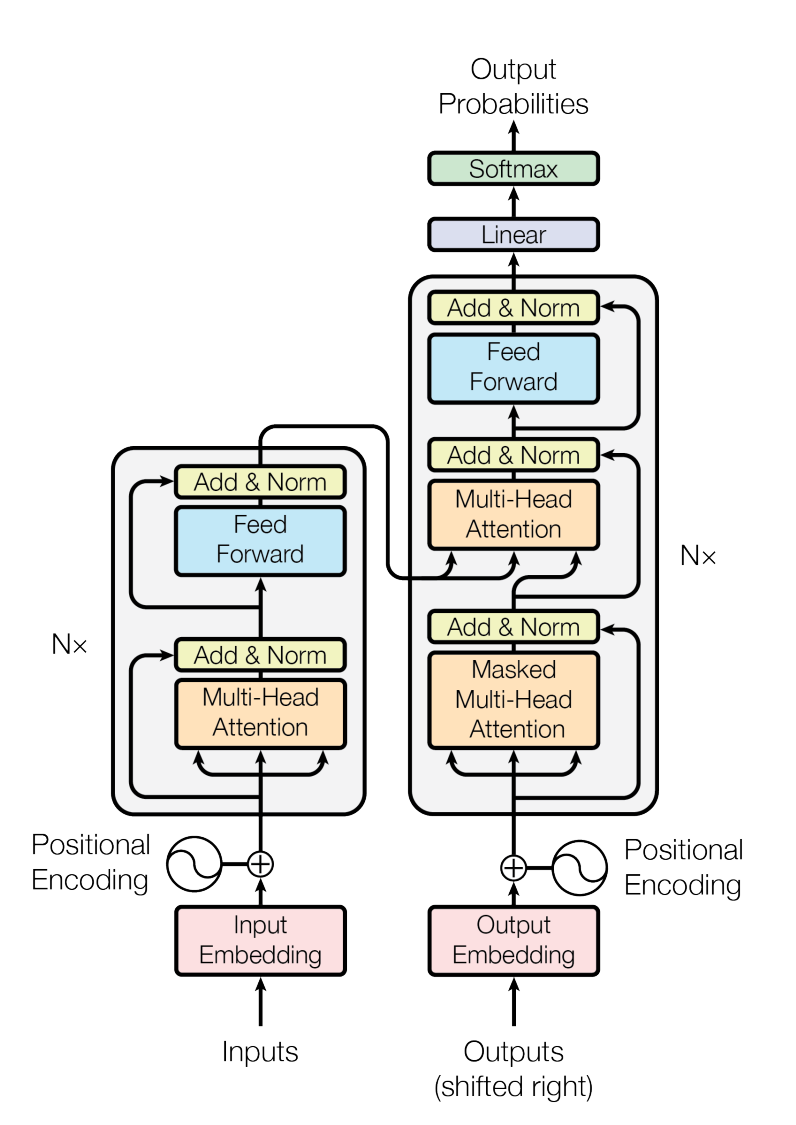

## EncoderLayer 编码器层

In [85]:
class EncoderLayers(nn.Module):
    def __init__(self, d_model, heads, dropout=0.1):
        super().__init__()
        self.norm_1 = NormLayer(d_model)
        self.norm_2 = NormLayer(d_model)
        self.attn = MultiHeadAttention(heads, d_model, dropout)
        self.ff = FeedForward(d_model)
        self.dropout_1 = nn.Dropout(dropout)
        self.dropout_2 = nn.Dropout(dropout)
    
    def forward(self, x, mask):
        # x的形状是(batch_size, seq_len, d_model)
        x2 = self.norm_1(x)
        # x2的形状是(batch_size, seq_len, d_model)
        x = x + self.dropout_1(self.attn(x2, x2, x2, mask))
        # x的形状是(batch_size, seq_len, d_model)
        x2 = self.norm_2(x)
        # x2的形状是(batch_size, seq_len, d_model)
        x = x + self.dropout_2(self.ff(x2))
        # x的形状是(batch_size, seq_len, d_model)
        return x
    
class Encoder(nn.Module):
    def __init__(self, vocab_size, d_model, heads, N, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        self.N = N
        self.embed = nn.Embedding(vocab_size, d_model)
        self.pe = PositionalEncoder(d_model)
        self.dropout = nn.Dropout(dropout)
        self.layers = nn.ModuleList([EncoderLayers(d_model, heads, dropout) for _ in range(self.N)])
        self.norm = NormLayer(d_model)

    def forward(self, x, mask):
        # x的形状是(batch_size, seq_len)
        x = self.embed(x)  # Embedding化
        # x的形状是(batch_size, seq_len, d_model)
        x = self.pe(x) # 加入位置编码
        # x的形状是(batch_size, seq_len, d_model)
        x = self.dropout(x)
        for i in range(self.N):
            x = self.layers[i](x, mask)
        # x的形状是(batch_size, seq_len, d_model)
        return self.norm(x) # (batch_size, seq_len, d_model)

## DecoderLayer 解码器层

In [86]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, heads, dropout=0.1):
        super().__init__()
        self.norm_1 = NormLayer(d_model)
        self.norm_2 = NormLayer(d_model)
        self.norm_3 = NormLayer(d_model)
        self.dropout_1 = nn.Dropout(dropout)
        self.dropout_2 = nn.Dropout(dropout)
        self.dropout_3 = nn.Dropout(dropout)
        self.attn_1 = MultiHeadAttention(heads, d_model, dropout)
        self.attn_2 = MultiHeadAttention(heads, d_model, dropout)
        self.ff = FeedForward(d_model)
    
    def forward(self, x, e_outputs, src_mask, trg_mask):
        # x的形状是(batch_size, seq_len, d_model)
        x2 = self.norm_1(x)
        # x2的形状是(batch_size, seq_len, d_model)
        x = x + self.dropout_1(self.attn_1(x2, x2, x2, trg_mask))
        # x的形状是(batch_size, seq_len, d_model)
        x2 = self.norm_2(x)
        # x2的形状是(batch_size, seq_len, d_model)
        x = x + self.dropout_2(self.attn_2(x2, e_outputs, e_outputs, src_mask))
        # x的形状是(batch_size, seq_len, d_model)
        x2 = self.norm_3(x)
        # x2的形状是(batch_size, seq_len, d_model)
        x = x + self.dropout_3(self.ff(x2))
        # x的形状是(batch_size, seq_len, d_model)
        return x
    
class Decoder(nn.Module):
    def __init__(self, vocab_size, d_model, heads, N, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        self.N = N
        self.embed = nn.Embedding(vocab_size, d_model)
        self.pe = PositionalEncoder(d_model)
        self.dropout = nn.Dropout(dropout)
        self.layers = nn.ModuleList([DecoderLayer(d_model, heads, dropout) for _ in range(self.N)])
        self.norm = NormLayer(d_model)
    
    def forward(self, trg, e_outputs, src_mask, trg_mask):
        # trg的形状是(batch_size, seq_len)
        # e_outputs的形状是(batch_size, seq_len, d_model)
        # src_mask的形状是(batch_size, 1, 1, src_len)
        # trg_mask的形状是(batch_size, 1, trg_len, trg_len)
        x = self.embed(trg)
        # x的形状是(batch_size, seq_len, d_model)
        x = self.pe(x) # 加入位置编码
        for i in range(self.N):
            x = self.layers[i](x, e_outputs, src_mask, trg_mask)
        return self.norm(x) # (batch_size, seq_len, d_model)

## Transformers 结构

In [87]:
class Transformers(nn.Module):
    def __init__(self, src_vocab, trg_vocab, d_model, heads, N, dropout=0.1):
        super().__init__()
        self.encoder = Encoder(src_vocab, d_model, heads, N, dropout)
        self.decoder = Decoder(trg_vocab, d_model, heads, N, dropout)
        self.out = nn.Linear(d_model, trg_vocab)
    
    def forward(self, src, trg, src_mask, trg_mask):
        # src的形状是(batch_size, src_len)
        # trg的形状是(batch_size, trg_len)
        # src_mask的形状是(batch_size, 1, 1, src_len)
        # trg_mask的形状是(batch_size, 1, trg_len, trg_len)
        e_outputs = self.encoder(src, src_mask)
        # e_outputs的形状是(batch_size, src_len, d_model)
        d_output = self.decoder(trg, e_outputs, src_mask, trg_mask)
        # d_output的形状是(batch_size, trg_len, d_model)
        output = self.out(d_output)
        # output的形状是(batch_size, trg_len, trg_vocab)
        return output

In [91]:
# 定义模型参数
src_vocab = 5000
trg_vocab = 5000
d_model = 512
heads = 32
N = 64
dropout = 0.1

# 创建模型
model = Transformers(src_vocab, trg_vocab, d_model, heads, N, dropout)
model

Transformers(
  (encoder): Encoder(
    (embed): Embedding(5000, 512)
    (pe): PositionalEncoder()
    (dropout): Dropout(p=0.1, inplace=False)
    (layers): ModuleList(
      (0-63): 64 x EncoderLayers(
        (norm_1): NormLayer()
        (norm_2): NormLayer()
        (attn): MultiHeadAttention(
          (q_linear): Linear(in_features=512, out_features=512, bias=True)
          (v_linear): Linear(in_features=512, out_features=512, bias=True)
          (k_linear): Linear(in_features=512, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (out): Linear(in_features=512, out_features=512, bias=True)
        )
        (ff): FeedForward(
          (linear_1): Linear(in_features=512, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear_2): Linear(in_features=2048, out_features=512, bias=True)
        )
        (dropout_1): Dropout(p=0.1, inplace=False)
        (dropout_2): Dropout(p=0.1, inplace=False)
 